## Imports

In [92]:
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

In [93]:
print('Loading Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial = dist_pickle["spatial"]
hist_bins = dist_pickle["hist_bins"]

print('Loading is done!')

Loading Classifier parameters...
Loading is done!


## Feature Extraction Method

In [94]:
def raw_pixel_intensity(src, size=(32, 32)):
    src_r = cv2.resize(src, size)
    src_r = src_r.flatten()
    
    return src_r 

def histogram_of_pixel_intensity(src, size=32): 
    hist1 = cv2.calcHist(images=[src], channels=[0], mask=None, histSize=[size], ranges=[0, 256])
    hist2 = cv2.calcHist(images=[src], channels=[1], mask=None, histSize=[size], ranges=[0, 256])
    hist3 = cv2.calcHist(images=[src], channels=[2], mask=None, histSize=[size], ranges=[0, 256])

    hist1 = hist1.flatten()
    hist2 = hist2.flatten()
    hist3 = hist3.flatten()

    hist = np.concatenate((hist1,hist2,hist3))
    return hist

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image

    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

## Window Search

In [95]:
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=0, visualisation=False):
    bbox_detection_list=[]
    box_vis_list=[]

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
       
    for (ystart, ystop, scale) in ystart_ystop_scale:
        
        box_vis=[]

        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape            
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int64(imshape[1]/scale), np.int64(imshape[0]/scale)))
                    
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2        

        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1        

        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) 
                
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
             
             
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))                


                spatial_features = raw_pixel_intensity(subimg, size=spatial_size)
                hist_features = histogram_of_pixel_intensity(subimg)


                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                

                test_prediction = svc.predict(test_features)
                
                if(visualisation):
                    xbox_left = np.int64(xleft*scale)
                    ytop_draw = np.int64(ytop*scale)
                    win_draw = np.int64(window*scale)

                    box_vis.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                if test_prediction == 1:
                    xbox_left = np.int64(xleft*scale)
                    ytop_draw = np.int64(ytop*scale)
                    win_draw = np.int64(window*scale)

                    bbox_detection_list.append(((xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart)))

                    cv2.rectangle(draw_img,(xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart),(0,0,255),6) 
        box_vis_list += [box_vis]
    return bbox_detection_list, draw_img, box_vis_list

## Draw Bounding Box

In [96]:
def add_heat(heatmap, bbox_list):

    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return img

In [97]:
### Parameters
spatial = spatial
hist_bins = hist_bins
#colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = orient
pix_per_cell = pix_per_cell
cell_per_block = cell_per_block
spatial_size= (spatial, spatial)
heat_threshold= 4 # 12
#hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

def process_image(img): 
    
    bbox_detection_list, detections, box_vis_list = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

    blank = np.zeros_like(img[:,:,0]).astype(np.float)

    heatmap = add_heat(blank, bbox_detection_list)

    heatmap = apply_threshold(heatmap,1)

    heatmap = np.clip(heatmap, 0, 255)

    labels = label(heatmap)

    result = draw_labeled_bboxes(np.copy(img), labels)
    
    return result

## Detect Test Images

In [98]:
test_images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')])

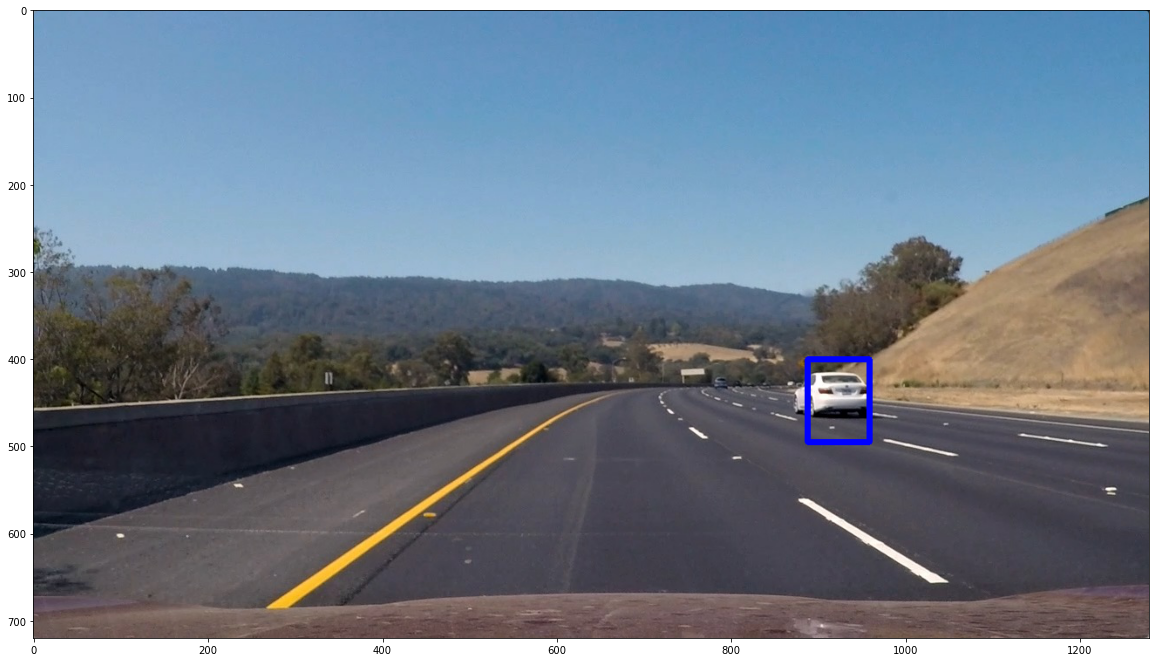

In [106]:
result = process_image(test_images[2])
plt.figure(figsize = (20,20))
plt.imshow(result)
#plt.axis("off")

In [108]:
#detect_history = Detect_history()
project_video_res = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image)
project_video_clip.write_videofile(project_video_res, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_result.mp4.
Moviepy - Writing video project_video_result.mp4



Moviepy - Done !
Moviepy - video ready project_video_result.mp4
